In [4]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
from astropy.stats import mad_std
import astropy.units as u

import pandas as pd

from jas1101finalproject import GlobularCluster
from jas1101finalproject import plot
from jas1101finalproject.plot import LogNorm, AsinhNorm
from jas1101finalproject.utils import profile_binning

from jas1101finalproject.fit import sigmar_2
from jas1101finalproject.fit import set_prior, set_likelihood
from jas1101finalproject.fit import DynamicNestedSampler

from jas1101finalproject.plot import colorbar_non_mappable

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read GC

In [2]:
gc_name = "NGC_6121_M_4"

GC = GlobularCluster.from_name(gc_name)
GC.table_full[:10]

x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm,member_prob_GMM,member_prob_DB
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,,,deg,mas / yr,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
-0.1149705,-0.4597388,-4.211758,2.089228,1.118624,0.8817772,-0.4453271,19.62006,1.373169,0,0.0,0.47389659219674707,4.701465631752294,0.0,0.0
-0.15697,-0.4717856,-8.474597,-5.547275,1.254753,0.9794271,-0.4192878,19.72522,1.63183,0,0.0,0.49721346850961307,10.128724215716113,0.0,0.0
-0.1048919,-0.4773524,-0.2552977,2.306975,1.383632,1.116302,-0.5530814,19.8323,1.279495,0,0.0,0.48874085615116114,2.321058070417518,0.0,0.0
-0.101432,-0.4847457,0.3841891,-1.890235,1.57732,1.322556,-0.5498436,20.01393,1.05652,0,0.0,0.4952442269148526,1.9288829979508375,0.0,0.0
-0.1445432,-0.4718092,-0.6602834,-5.167095,2.422973,2.022898,-0.4094181,20.56623,2.330395,0,0.0,0.49345380520458043,5.209111719606382,0.0,0.0
-0.124151,-0.4824432,-4.231748,-4.185622,1.068998,0.8952284,-0.4816412,19.32735,1.500933,1,0.0,0.4981615320628842,5.952068771644696,0.0,0.0
-0.1381598,-0.4663045,-0.664471,-5.310302,3.695026,2.918999,-0.03780777,20.88632,1.603117,0,0.0,0.48634146137902945,5.35171272033963,0.0,0.0
-0.1318836,-0.4268219,-3.980419,-6.452318,0.5708521,0.3378795,-0.201703,18.12574,1.468092,1,0.0,0.4467328264954009,7.58130219610622,0.0,0.0


In [3]:
GC.summary

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_6121_M_4,245.896,-26.525,2.2,71.0,0.1,4.7,30.0,-12.49,-19.001,0.044,0.044,-0.001,7526.3,8.63,0.563,0.469,0.018,22.738471826400296,"-0.8038941811268694,-1.796791404175595,-0.9824941706855336"


### Distibution of PM-R with Eugene's GMM membership

In [5]:
good = GC.pm_e < 2

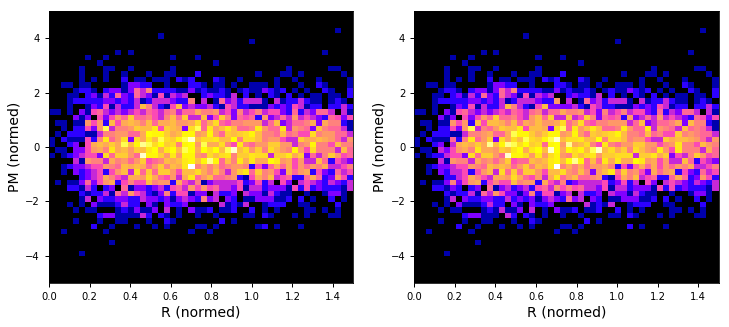

In [6]:
# display r-pm hist2d
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

H, xb, yb, _ = ax1.hist2d(GC.r, GC.pm-GC.pm.mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")
H, xb, yb, _ = ax2.hist2d(GC.r[good], GC.pm[good]-GC.pm[good].mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")

for ax in ax1, ax2:
    ax.set_xlabel("R (normed)") # normalized
    ax.set_ylabel("PM (normed)") # normalized

### Distribution in Radius

0.3885428003243504 0.9106340497342862


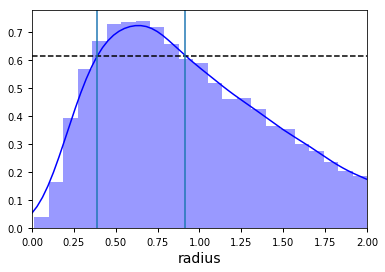

In [84]:
p = sns.distplot(GC.r[good], color='blue')
x_kde, y_kde = p.get_lines()[0].get_data()

x_peak = x_kde[np.argmax(y_kde)]
y_sol = y_kde.max()*0.85
left, right = x_kde<x_peak, x_kde>x_peak
x_left, x_right = [x_kde[side][np.argmin(abs(y_kde-y_sol)[side])] for side in (left, right)]
print(x_left, x_right)

plt.axhline(y_sol, color='k', ls='--')
plt.xlim(0,2)
plt.xlabel('radius')
plt.axvline(x_left)
plt.axvline(x_right)

## Draw comparison of binned sigma profiles 
#### 1) with Eugene's GMM membership
#### 2) HDBSCAN membership
#### 3) without memeber selection.

In [105]:
# parameter of GC
M_gc = 1e4
r_scale = 100

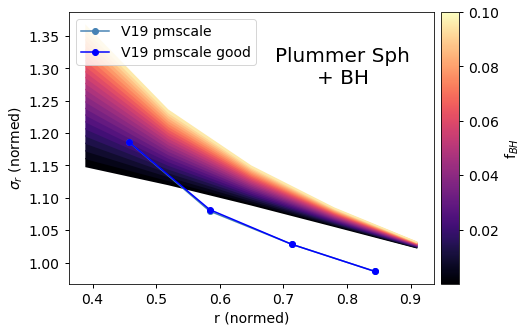

In [113]:
r_min, r_max = x_left, x_right
bins = np.linspace(r_min, r_max, 5)

fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, color='steelblue', label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='blue', label='V19 pmscale good')

plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(bins, M_gc, r_scale, 
                                          beta_max=0.1, N_mod=25, fig=fig)

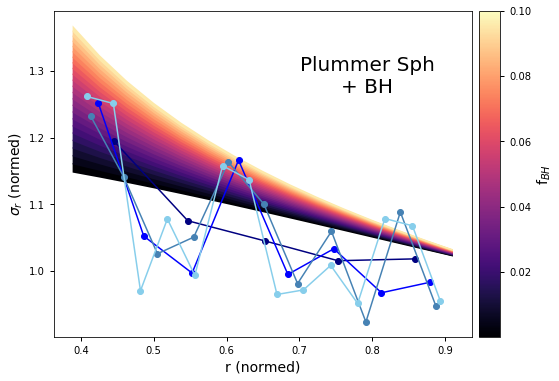

In [89]:
fig=plt.figure(figsize=(8,6))

bins = np.linspace(r_min, r_max, 6)
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='navy', label='V19 pmscale good')

bins = np.linspace(r_min, r_max, 9)
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='blue', label='V19 pmscale good')

bins = np.linspace(r_min, r_max, 12)
fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, fig=fig, bins=bins, color='steelblue', label='V19 pmscale')

bins = np.linspace(r_min, r_max, 15)
fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, fig=fig, bins=bins, color='skyblue', label='V19 pmscale')


# fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='y', label='DB pmscale')
# fig = plot.plot_binned_sigma_profile(GC_DB.r[good_DB], GC_DB.pm[good_DB], bins=bins, fig=fig, color='gold', label='DB pmscale good')
# plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(bins, M_gc, r_scale, beta_max=0.1, N_mod=25, fig=fig)

## Fitting sigma profile of a single cluster

In [90]:
# r_min, r_max = 0.1, 1.5
r, pm, pm_e = GC.r, GC.pm, GC.pm_e

# conditional cut
cond = (r>=r_min) & (r<=r_max) & (pm_e < 2)

# x and y, y_err for fitting
pm, pm_e = pm[cond], pm_e[cond]
r = r[cond]

PM = 48.473 +/- 1.066 


Text(0.5, 0, 'PM')

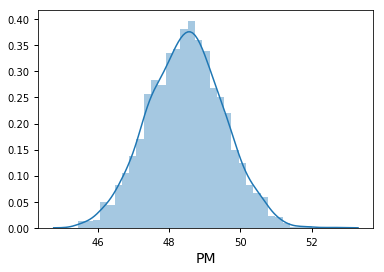

In [91]:
sns.distplot(pm)
print("PM = %.3f +/- %.3f "%(np.mean(pm), mad_std(pm)))
plt.xlabel("PM")

### Setup prior and likelihood

In [92]:
kind = 'scale-outlier'

prior, ndim = set_prior(kind=kind, logbeta_max=-1, scale_max=25, mu_ol_max=100)
loglike = set_likelihood(r, pm, y_err=pm_e, kind=kind)

### Run Fitting

In [97]:
dsampler = DynamicNestedSampler(loglike, prior, ndim)
dsampler.run_fitting(nlive_init=600, maxbatch=10)


Opening new pool: # of CPU used: 3
Run Nested Fitting for the image... Dim of params: 6


iter: 6421 | batch: 10 | bound: 100 | nc: 5 | ncall: 38951 | eff(%): 16.485 | loglstar: -4036.743 < -4033.741 < -4034.673 | logz: -4040.455 +/-  0.137 | stop:  2.265                                 



Finish Fitting! Total time elapsed: 137 s

Pool Closed.


## Visualizing Fitting Result

## 1.  Fit in R$_{left}$ < R < R$_{right}$

#### Eugene's membership

without measurement error / outlier

with measurement error and outlier

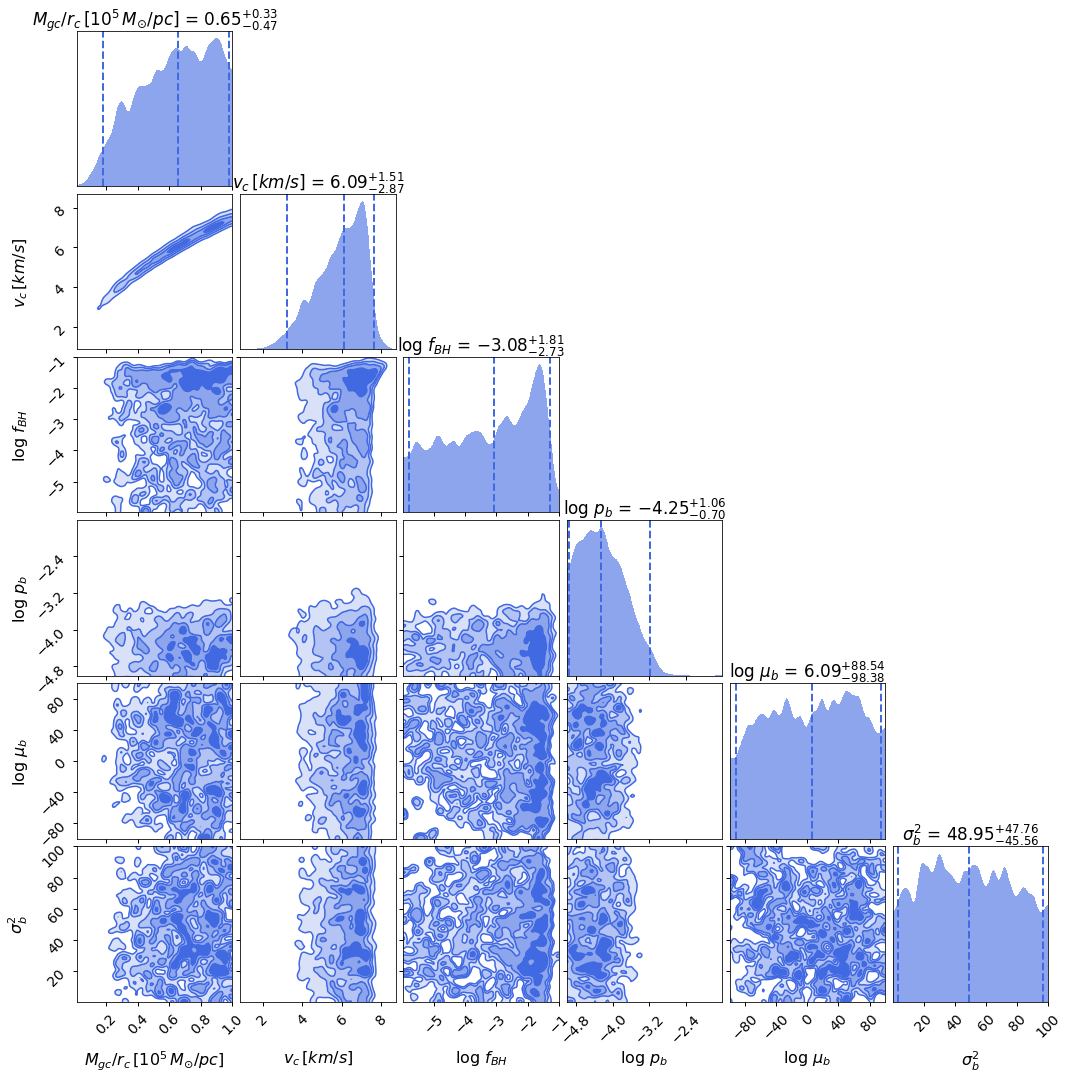

In [134]:
# Plot result joint and marginal PDF
labels = [r'${M_{gc}}/{r_{c}}\,[10^5\,M_{\odot}/{pc}]$',
          '$v_{c}\,[km/s]$', r'log $f_{BH}$',
          r'log $p_{b}$', r'log $\mu_{b}$', r'$\sigma^2_{b}$']
dsampler.cornerplot(figsize=(15,15),labels=labels)
plt.savefig("../../pic/CornerPlot_M4.pdf")

In [115]:
pmed, _, _, samples = dsampler.get_params(return_sample=True)

In [129]:
qs = np.quantile(samples[:,2], [0.68, 0.95, 0.997])
    
print("1/2/3 sigma upper limit BH fraction: {0:.3g}/{1:.3g}/{2:.3g}".format(*10**qs))

1/2/3 sigma upper limit BH fraction: 0.00558/0.0421/0.0811


## 2. Fit in 0.4 < R < 1

#### Eugene's membership

with measurement error and outlier

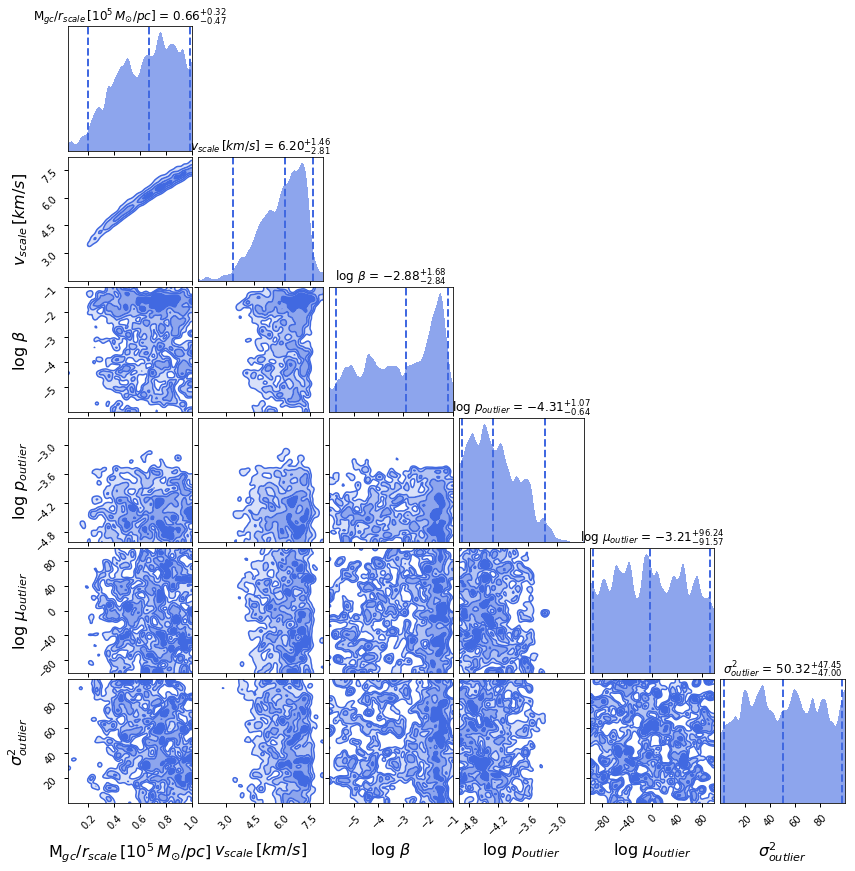

In [41]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$']
dsampler.cornerplot(figsize=(12,12),labels=labels)